# TODO
* LibLinear vs Scapy vs other?

* Class imbalance in linear regreassion
http://www.chioka.in/class-imbalance-problem/

* What to use at all in negative points?

* Read about all the grid details


## Drawing a map

using shapefiles with Basemap
source of map: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/9wp7-iasj
programming docs: 
* https://stackoverflow.com/questions/21053081/mapping-gps-coordinates-around-chicago-using-basemap
* https://basemaptutorial.readthedocs.io/en/latest/shapefile.html

## KDE

https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

Bandwith Selection (Hpi):
https://cran.r-project.org/web/packages/ks/ks.pdf
"we used the default plug-in bandwidth estimator (Hpi) with a dscalar pilot to obtain an optimal value for h. This standard approach is widely used by crime analysts to estimate crime densities."

I'll use:
https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.gaussian_kde.html


Good code example:
http://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html

# Crime Prediction

## Problem Definition
Given a day $d$ and geocoordinates $p$ in Chicago, what are the probabilities of each crime to happnen in this time frame and location?

## Model - Linear Regression

**[ECHT?!]** There is a different model for each crime type $L_{crime}$.

### Structure

For a specific day $d$,
for a specific geocoordinates $p$,
the **features** are calaculated.

In other words, the model is blind to the (1) day $d$ and to the (2) location $p$. 

### Features

1. $f_{KDE}$ - is different for each $L_{crime}$/
2. $f$


## Data Sets
### Training Set - ECHT?!
Training the model on a 31-day window.
The first 30 days are used for calculating the features (predictors), for each crime in the last day.

In other words, for each crime that happend in the last day, the location points are extracted (rows). For each one of these points (location + crime type), the features are calculated.

To predict the occurrence of crime type T, we first defined a one-month training window (January 1, 2013 – January 31, 2013). We then put down labeled points (latitude/longitude pairs) across the city limits of Chicago. These points came from two sources: (1) from the locations of known crimes of type T within the training window (these points received a label T), and (2) from a grid of evenly spaced points at 200-meter intervals, not coinciding with points from the first set (these points received a label NONE).

### Test Set

**[ECHT?!]** Sounds stupid to me - in the training window i'm using information from the future to predict the past, this is not part of the practical modical execution! Maybe I don't understand what is written?

Making predictions for the first day following the training window, and  sliding one day into the future and repeating. This mirrors a practical setup where a new predictions are run each day.

The set of prediction points included those obtained by evenly spacing points at 200-meter intervals across the prediction area. We also added to the set of prediction points all points where crimes of type T occurred during the training window. We added these points to force higher-resolution predictions in areas where we had observed more crime in the past. In any case, a prediction point was simply a latitude-longitude pair containing no ground-truth information about future crime.


## Technical Details

* LibLinear
* To counter the effects of class imbalance (there are far more negative points than positive points), we set LibLinear’s C parameter to N/P , with N and P being P the counts of negative and positive points in the training set, respectively.



## Evaluation Crietria

 surveillance plot mea- sures the percentage of true T crimes during the prediction window (y-axis) that occur within the x% most threatened area according to the model’s prediction for T.
 
 We produced scalar summaries for surveillance curves by calculating the total area under the curve (AUC). Better prediction performance is indicated by curves that approach the upper-left corner of the plot area or, equivalently, by curves with higher AUC scores. An optimal prediction sorts the 200-meter pre-
20
 
          Aggregated (AUC=0.7211)
                 0.0 0.2 0.4 0.6 0.8 1.0 % area surveilled
Figure 7: Example surveillance plot showing the number of true crimes captured (y-axis) in the x% most threatened area according to the model’s prediction. AUC indicates total area under the surveillance curve.
diction squares in descending order of how many future crimes they will contain. This property makes surveillance plots appropriate for decision makers, who must allocate scarce resources (e.g., police patrols) across the geographic space. Lastly, because each model execution produced a series of surveillance plots for crime type T , one for each prediction day, we aggre- gated the plots to measure a model’s overall performance. For example, to compute a model’s aggregate y-value for crime type T at an x-value of 5%, we first summed the number of true T crimes occurring in the top 5% most threatened area for each prediction day. We then divided that sum by the
21
% incidents captured
0.0 0.2 0.4 0.6 0.8 1.0
total number of true T crimes occurring across all prediction days. Doing this for each possible x-value produced an aggregate curve and aggregate AUC score, which we report in this article.


## LDA

1000m x 1000m neighberhod grid
N topics for each neighberhood given the tweets in the neigberhood
Each neighberhood is a document, so we get the probability of each topic in the document

It will be for the same point of 200 in 1000 the same topic, then using "distance-weighted spatial interpolation"

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt

from tqdm import tqdm_notebook

In [2]:
crimes = pd.read_csv('../data/Crimes_-_2001_to_present.csv', nrows=1000)

crimes.rename(columns={'Primary Type': 'type',
                       'Longitude': 'lon',
                       'Latitude': 'lat'}, inplace=True)

crimes['timestamp'] = pd.to_datetime(crimes['Date'])

In [ ]:
crimes.columns

In [3]:
pd.DataFrame({
    'counts (x1000)': crimes['type'].value_counts(),
    'percents': (crimes['type'].value_counts(normalize=True) * 100).apply(lambda x : '{:.3f}%'.format(x))
})

,counts (x1000),percents
THEFT,187,18.700%
BATTERY,172,17.200%
NARCOTICS,125,12.500%
CRIMINAL DAMAGE,105,10.500%
MOTOR VEHICLE THEFT,65,6.500%
OTHER OFFENSE,63,6.300%
ASSAULT,60,6.000%
BURGLARY,46,4.600%
CRIMINAL TRESPASS,42,4.200%
ROBBERY,42,4.200%


In [5]:
jan17_crimes = crimes[(crimes['timestamp'] >= '2017-01-01') & (crimes['timestamp'] <= '2017-01-31')]

/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4773: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4774: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4780: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4811: RuntimeWarning: invalid value encountered in less
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4811: RuntimeWarning: invalid value encountered in greater
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)


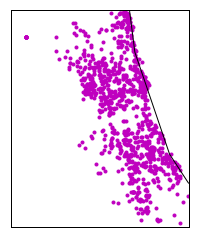

In [9]:
from mpl_toolkits.basemap import Basemap

#                   Lower Left Corner     Upper Right Corner
CHICAGO_COORDS = {'ll': {'lon': -87.94011, 'lat': 41.64454},
                  'ur': {'lon': -87.52413, 'lat': 42.02303}}

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


m = Basemap(llcrnrlon=CHICAGO_COORDS['ll']['lon'],
              llcrnrlat=CHICAGO_COORDS['ll']['lat'],
              urcrnrlon=CHICAGO_COORDS['ur']['lon'],
              urcrnrlat=CHICAGO_COORDS['ur']['lat'],
             resolution='i',
            projection='merc', lat_0=36.66666666666666, lon_0=36.6)

m.drawcoastlines()
#m.drawstates()
m.drawmapboundary(fill_color='white')
#m.readshapefile('../data/chicago_neighborhoods_maps/Neighborhoods_2012b', 'chicago')

k=1000
m.scatter(crimes['lon'].head(k).as_matrix(),
          crimes['lat'].head(k).as_matrix(),
          latlon=True,
          marker='.',color='m')


plt.show()

In [ ]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

In [16]:
Xtrain.shape

(1624, 2)

In [17]:
construct_grids(data)

(array([-94.75, -94.7 , -94.65, ..., -34.3 , -34.25, -34.2 ]),
 array([-56.  , -55.95, -55.9 , ...,  23.45,  23.5 ,  23.55]))

In [20]:
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])

In [21]:
X

array([[-94.75, -94.5 , -94.25, ..., -34.75, -34.5 , -34.25],
       [-94.75, -94.5 , -94.25, ..., -34.75, -34.5 , -34.25],
       [-94.75, -94.5 , -94.25, ..., -34.75, -34.5 , -34.25],
       ..., 
       [-94.75, -94.5 , -94.25, ..., -34.75, -34.5 , -34.25],
       [-94.75, -94.5 , -94.25, ..., -34.75, -34.5 , -34.25],
       [-94.75, -94.5 , -94.25, ..., -34.75, -34.5 , -34.25]])

In [22]:
np.meshgrid?

 - computing KDE in spherical coordinates
 - plot coastlines using basemap
 - computing KDE in spherical coordinates
 - plot coastlines using basemap


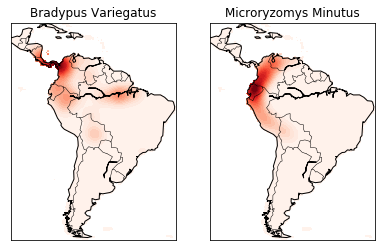

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.

# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = -9999 + np.zeros(land_mask.shape[0])
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c')
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(X, Y, land_reference,
                    levels=[-9999], colors="k",
                    linestyles="solid")
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()